In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

In [ ]:
valid_txt = np.loadtxt(path/'valid.txt', dtype=str); valid_txt

array(['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png', '0016E5_07965.png', ..., '0016E5_08153.png',
       '0016E5_08155.png', '0016E5_08157.png', '0016E5_08159.png'], dtype='<U16')

## Data

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_007980.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01740.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01110.png')]

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_02400_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f00540_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07590_P.png')]

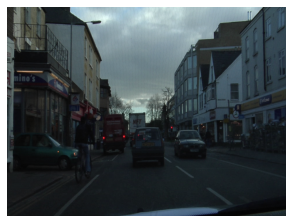

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

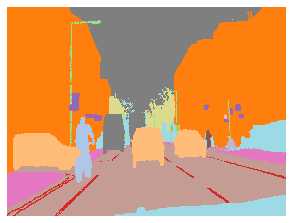

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [10, 10, 10,  ..., 30, 30, 30],
          [10, 10, 10,  ..., 30, 30, 30],
          [10, 10, 17,  ..., 30, 30, 30]]]))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [ ]:
size = src_size//2

In [ ]:
bs = 4

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

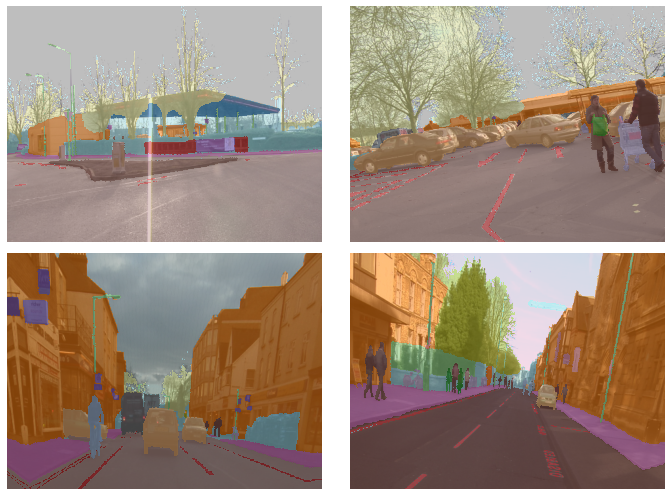

In [ ]:
data.show_batch(2, figsize=(10,7))

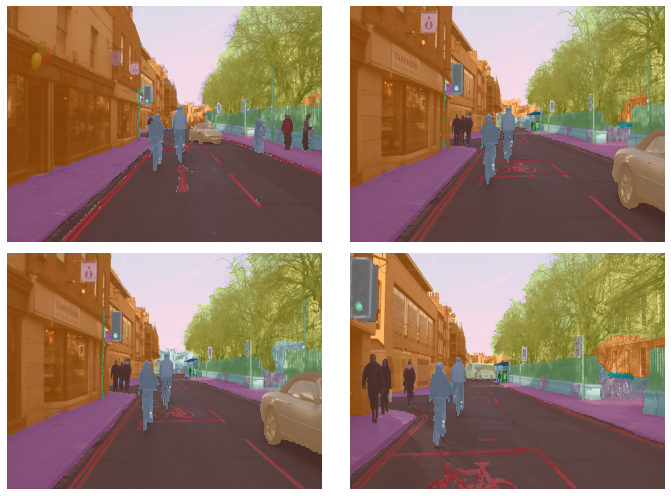

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


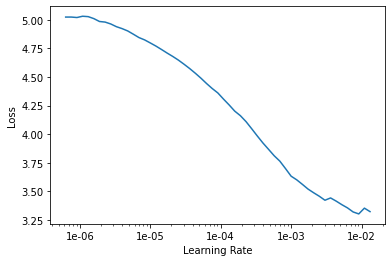

In [ ]:
# plot learning rate
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=3e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.829557,1.181362,0.706956,01:27
1,1.011128,0.708460,0.825801,01:26
2,0.768053,0.614508,0.838282,01:25
3,0.670112,0.567101,0.847426,01:26
4,0.577999,0.540310,0.842585,01:26
5,0.542317,0.438876,0.873903,01:25
6,0.520895,0.437458,0.872790,01:25
7,0.486026,0.390022,0.873914,01:25
8,0.437408,0.362904,0.895158,01:25
9,0.372765,0.295914,0.913485,01:25


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

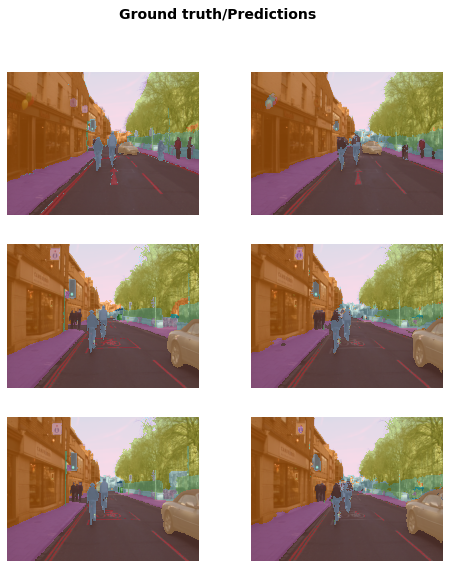

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


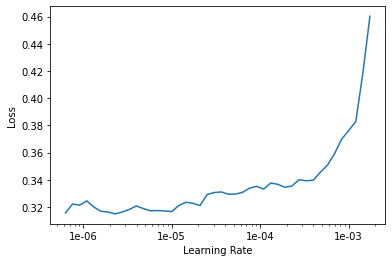

In [ ]:
learn.recorder.plot()

In [ ]:
lrs = slice(1e-06,lr/400)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.342193,0.294257,0.913946,01:30
1,0.339236,0.293299,0.914491,01:30
2,0.346486,0.294967,0.913693,01:30
3,0.336275,0.289674,0.915318,01:30
4,0.336336,0.293909,0.914085,01:29


In [ ]:
learn.save('stage-2');

## Train with bigger image size
We trained the model with half the original size. Our model performaned fairly well on the smaller images. 
 
Lets now train the model on the original size of the image.

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 5163MB of GPU RAM free


In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


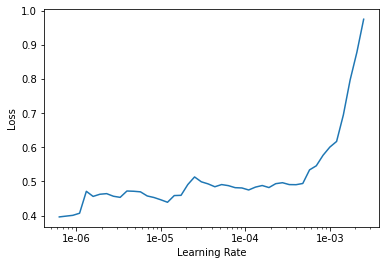

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.391017,0.318674,0.909953,03:20
1,0.367832,0.303020,0.914170,03:20
2,0.350462,0.297169,0.918830,03:20
3,0.342466,0.333724,0.901875,03:20
4,0.384103,0.313034,0.911203,03:20
5,0.361894,0.317792,0.916097,03:20
6,0.326753,0.262193,0.924407,03:20
7,0.273593,0.259664,0.923653,03:20
8,0.255317,0.307519,0.914069,03:20
9,0.224014,0.261824,0.926645,03:20


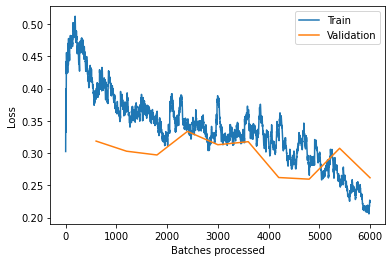

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


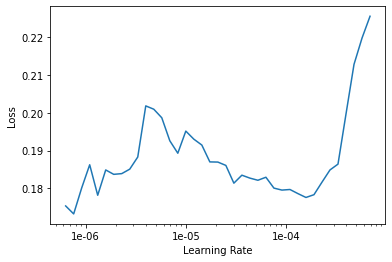

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-05,1e-04/5)

In [ ]:
learn.fit_one_cycle(4, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.191454,0.255549,0.929650,03:29
1,0.200226,0.266218,0.926349,03:29
2,0.201530,0.256124,0.930692,03:29
3,0.172607,0.256226,0.931069,03:29


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

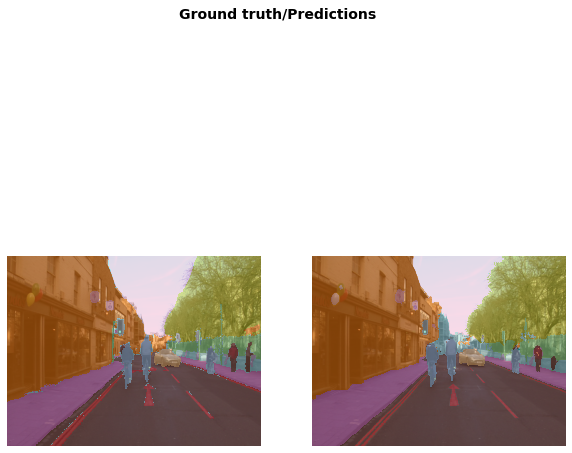

In [ ]:
learn.show_results(rows=3, figsize=(10,10))